In [1]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import xgboost
import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

In [2]:
con_evs = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-EVs.sqlite"))
con_game = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Gaming.sqlite"))
con_oil = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Oil.sqlite"))
#con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech.sqlite"))
con_tech = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-Tech2.sqlite"))
con_pnf = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-PnF.sqlite"))
#con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb-stock.sqlite"))
con_stock = sqlite3.connect(os.path.join(os.getcwd(), "../Database/fypdb.sqlite"))
con_res = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results.sqlite"))
con_res2 = sqlite3.connect(os.path.join(os.getcwd(), "../Database/results4.sqlite"))


cons = {
    "EVs": con_evs,
    "Gaming": con_game,
    "Oil": con_oil,
    "Tech": con_tech,
    "Pharma": con_pnf,
    "Food": con_pnf,
    "Stock": con_stock,
    "Results": con_res,
    "Results2": con_res2
}

In [3]:
tickers = {
    "EVs": ["TSLA", "LCID"],
    "Oil": ["COP", "XOM", "CVX"],
    "Pharma": ["PFE", "AZN", "MRNA"],
    "Food": ["MCD", "MDLZ", "PEP"],
    "Tech": ["GOOGL", "AAPL", "INTC", "MSFT"]
}

categories = ["EVs", "Oil", "Tech", "Pharma", "Food"]

#"Gaming": ["EA"]

#"Gaming": ["EA", "ATVI"],
#"Oil": ["COP", "XOM", "CVX", "ENB"],
#"Tech": ["GOOGL", "AAPL", "MSFT", "INTC"]

In [4]:
def load_datasets(cons, tickers, categories, reduce = False):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            if reduce == True:
                tweet_df = pd.read_sql_query(f"SELECT * from processed_tweets WHERE category='{category}'", cons["Results"])
                
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = -tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = -tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = -tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                
                tweet_df["neg_counts"] = -1 * tweet_df["neg_counts"]
                tweet_df["ind_neg"] = -1 * tweet_df["ind_neg"]
                tweet_df["wted_neg"] = -1 * tweet_df["wted_neg"]
                
                #tweet_df["mood"] = (tweet_df["pos_counts"] - tweet_df["neg_counts"]) / tweet_df["count"]

                tweet_df.sort_values(by=['date'])

                aggregate_dict = dict()

                for idx, row in tweet_df.iterrows():
                    key = f"{row['category']},{row['date']}"

                    if key in aggregate_dict:
                        aggregate_dict[key] = aggregate_dict[key] + row

                    else:
                        aggregate_dict[key] = row


                aggregate_dict_df = pd.DataFrame.from_dict(aggregate_dict, orient='index')   
                aggregate_dict_df.reset_index(drop=True, inplace=True)   
                aggregate_dict_df['date'] = aggregate_dict_df['date'].str.slice(0, 10)

                #print(aggregate_dict_df.head())

                aggregate_dict_df.drop(columns = ['category', 'ticker'], inplace=True)
                aggregate_dict_df["date"] = aggregate_dict_df["date"].astype("datetime64")

                tweet_dfs[ticker] = aggregate_dict_df.copy(deep=True)
                
            else:
                if category in ["Pharma", "Oil", "Tech", "EVs"]:    #use the new dataset results for Pharma ,Oil, Tech, EVs
                    #tweet_df = pd.read_sql_query(f"SELECT * from reduced_scored_tweets WHERE category='{category}'", cons["Results"])
                    tweet_df = pd.read_sql_query(f"SELECT * from reduced_tweet_counts WHERE category='{category}'", cons["Results2"])
                else:
                    tweet_df = pd.read_sql_query(f"SELECT * from new_scored_tweets WHERE category='{category}'", cons["Results"])

                tweet_df = tweet_df.drop(columns = ['category'])
                tweet_df["date"] = tweet_df["date"].astype("datetime64")
                tweet_df["count"] = tweet_df["count"].astype("int32")
                tweet_df["neg_counts"] = tweet_df["neg_counts"].astype("int32")
                tweet_df["neu_counts"] = tweet_df["neu_counts"].astype("int32")
                tweet_df["pos_counts"] = tweet_df["pos_counts"].astype("int32")
                tweet_df["ind_neg"] = tweet_df["ind_neg"].astype("float64")
                tweet_df["ind_neu"] = tweet_df["ind_neu"].astype("float64")
                tweet_df["ind_pos"] = tweet_df["ind_pos"].astype("float64")
                tweet_df["wted_neg"] = tweet_df["wted_neg"].astype("float64")
                tweet_df["wted_neu"] = tweet_df["wted_neu"].astype("float64")
                tweet_df["wted_pos"] = tweet_df["wted_pos"].astype("float64")
                #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])
                
                tweet_df["neg_counts"] = -1 * tweet_df["neg_counts"]
                tweet_df["ind_neg"] = -1 * tweet_df["ind_neg"]
                tweet_df["wted_neg"] = -1 * tweet_df["wted_neg"]
                
                tweet_dfs[ticker] = tweet_df.copy(deep=True)
            
            stock_df = pd.read_sql_query(f"SELECT * from stock_data WHERE ticker='{ticker}'", cons["Stock"])
            
            stock_df = stock_df.drop(columns = ['category', 'ticker'])

            stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
            stock_df["open"] = stock_df["open"].astype("float64")
            stock_df["close"] = stock_df["close"].astype("float64")
            stock_df["high"] = stock_df["high"].astype("float64")
            stock_df["low"] = stock_df["low"].astype("float64")

            stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
            
            stock_dfs[ticker] = stock_df.copy(deep=True)
            
            del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [5]:
tweet_dfs, stock_dfs = load_datasets(cons, tickers, categories, reduce = False)

In [6]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
            temp_stock_df = stock_dfs[ticker].copy(deep=True)

            temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
            temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
            
            
            merged_dfs[ticker] = temp_merged_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
            
            del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [7]:
def normalize_datasets(categories, tickers, merged_dfs, reduced = 0):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        for ticker in tickers[category]:
            
            temp_norm_df = merged_dfs[ticker].copy(deep=True)
            
            temp_norm_df = temp_norm_df.drop(columns=['date'])

            temp_norm_df = scaler.fit_transform(temp_norm_df)
            
            if reduced == 0: #For the complete datasets
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                                      'neg_counts', 'neu_counts', 'pos_counts'])
                
            elif reduced == 1: #For correlation heatmap
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                      'count','ind_neg','ind_neu', 'ind_pos', \
                                                                      'wted_neg', 'wted_neu', 'wted_pos', \
                                                                      'neg_counts', 'neu_counts', 'pos_counts'])
                
                temp_norm_df = temp_norm_df.drop(columns = ['high', 'low', 'count', 'ind_neg', 'ind_neu', 'ind_pos', \
                                             'neg_counts', 'neu_counts', 'pos_counts'])
            
            else: #For the reduced datasets
                #columns_dash = ['prev_open', 'ind_neg', 'ind_neu', 'ind_pos', 'prev_close', 'close', 'close_delta']
                columns = ['prev_open', 'wted_neg', 'wted_neu', 'wted_pos', 'close']
                temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
            
            norm_dfs[ticker] = temp_norm_df.copy(deep=True)
            
            print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
            
            del temp_norm_df
            
    return norm_dfs

In [8]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (717, 15) 

Data dimensions for LCID: (242, 15) 

Data dimensions for COP: (719, 15) 

Data dimensions for XOM: (719, 15) 

Data dimensions for CVX: (719, 15) 

Data dimensions for GOOGL: (722, 15) 

Data dimensions for AAPL: (722, 15) 

Data dimensions for INTC: (725, 15) 

Data dimensions for MSFT: (730, 15) 

Data dimensions for PFE: (730, 15) 

Data dimensions for AZN: (730, 15) 

Data dimensions for MRNA: (730, 15) 

Data dimensions for MCD: (730, 15) 

Data dimensions for MDLZ: (730, 15) 

Data dimensions for PEP: (730, 15) 



In [9]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs, reduced = 1)

Data dimensions for TSLA: (717, 5) 

Data dimensions for LCID: (242, 5) 

Data dimensions for COP: (719, 5) 

Data dimensions for XOM: (719, 5) 

Data dimensions for CVX: (719, 5) 

Data dimensions for GOOGL: (722, 5) 

Data dimensions for AAPL: (722, 5) 

Data dimensions for INTC: (725, 5) 

Data dimensions for MSFT: (730, 5) 

Data dimensions for PFE: (730, 5) 

Data dimensions for AZN: (730, 5) 

Data dimensions for MRNA: (730, 5) 

Data dimensions for MCD: (730, 5) 

Data dimensions for MDLZ: (730, 5) 

Data dimensions for PEP: (730, 5) 



In [10]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titl

In [11]:
def plot_corr_heatmaps(categories, tickers, norm_dfs, save=False):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        for ticker in tickers[category]:
            plt.figure(figsize=(10,6))
            g = sns.heatmap(norm_dfs[ticker].corr('spearman'), cmap='PuBuGn', annot=True, linewidths=0.2, annot_kws={"fontsize": 14})
            g.set_yticklabels(g.get_yticklabels(), rotation = 360)
            plt.title(f'Correlation Heatmap For {category}-{ticker}', fontsize=16)
            if save == True and ticker in ['TSLA', 'XOM', 'MSFT', 'MRNA']:
                plt.savefig(f'images/reduced-correlation-heatmap-{ticker}', transparent=True, dpi=500)
            plt.show()

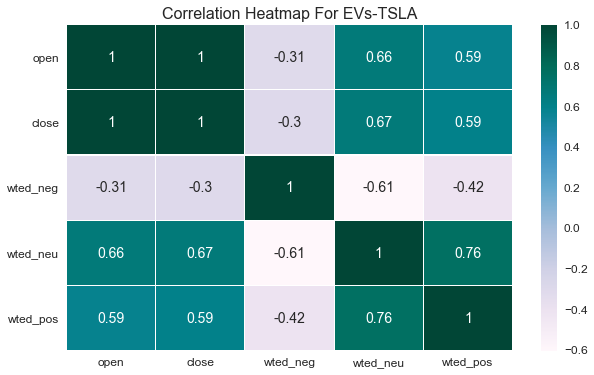

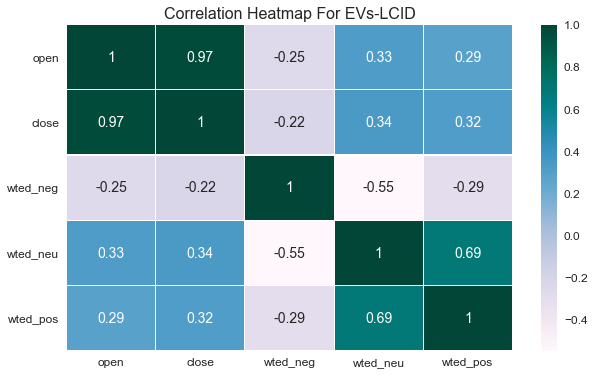

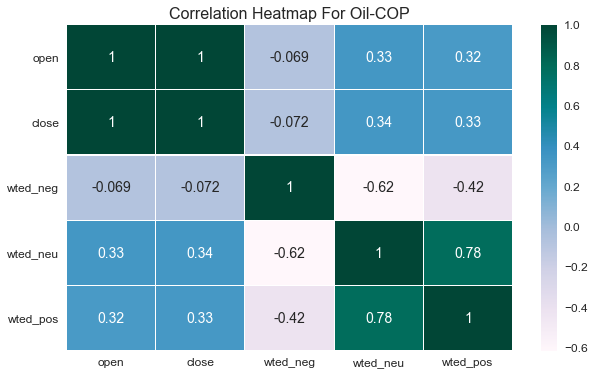

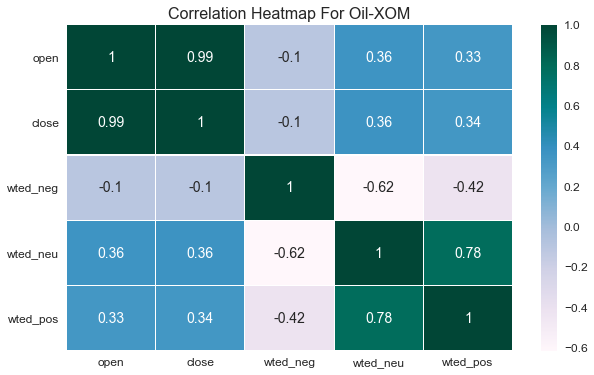

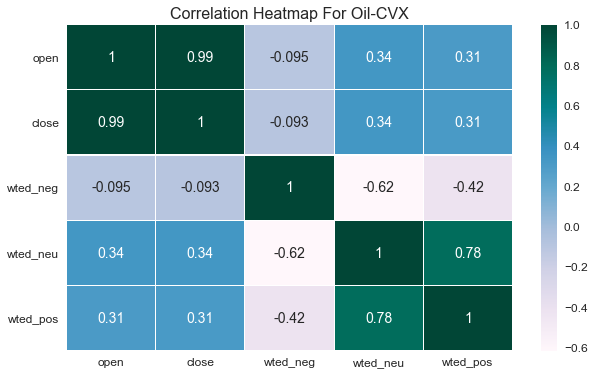

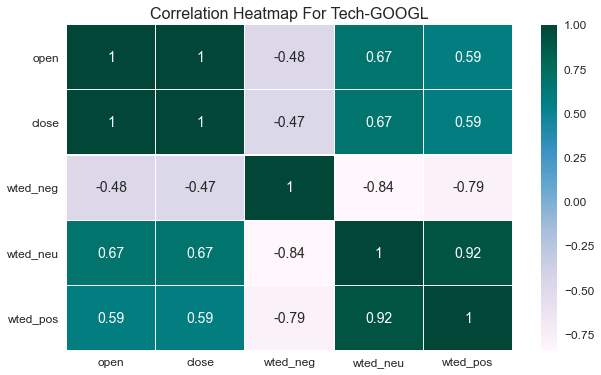

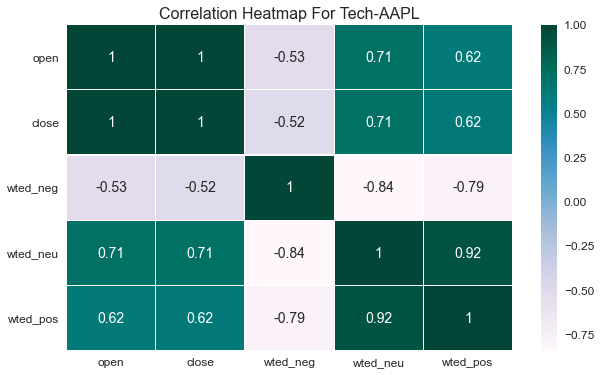

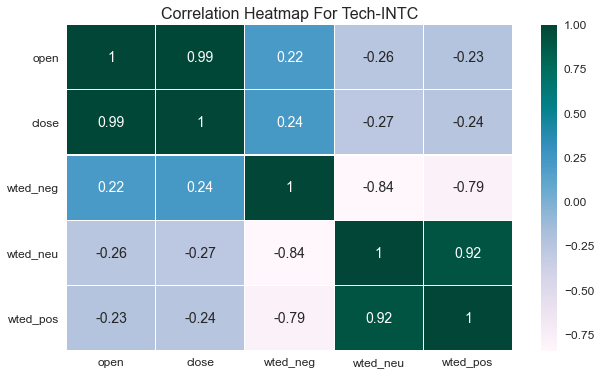

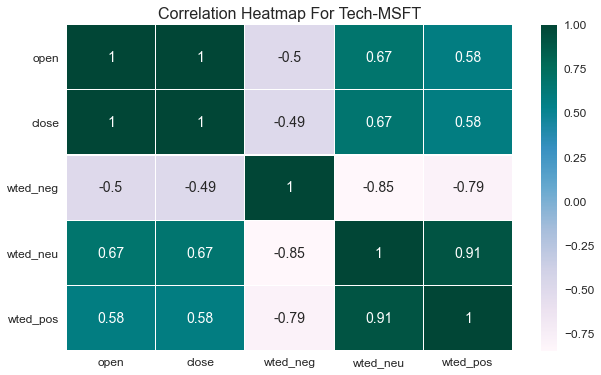

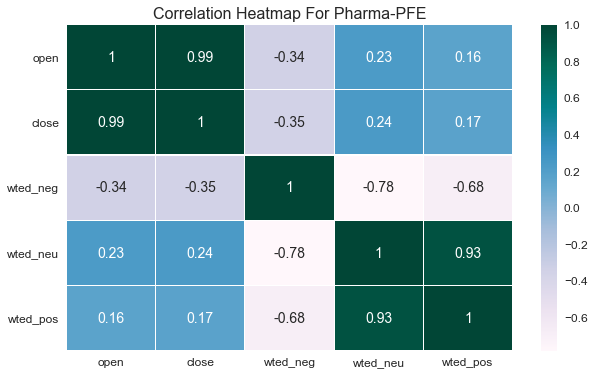

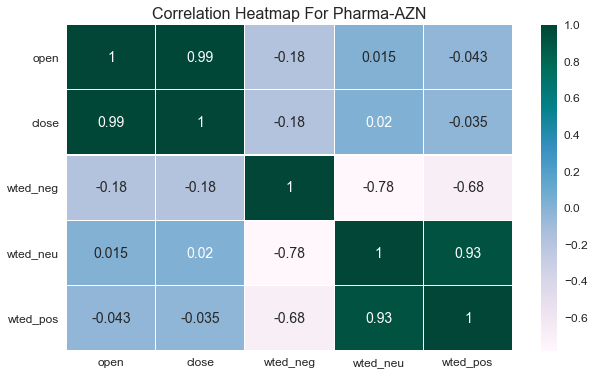

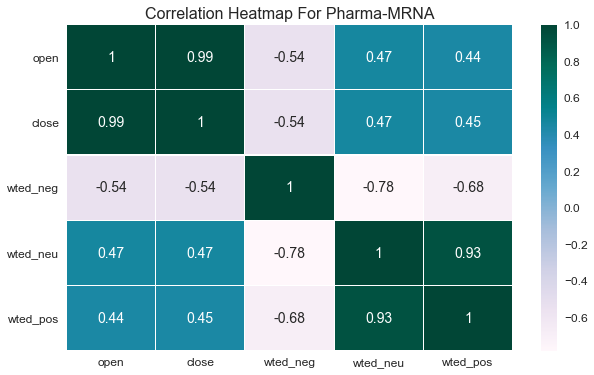

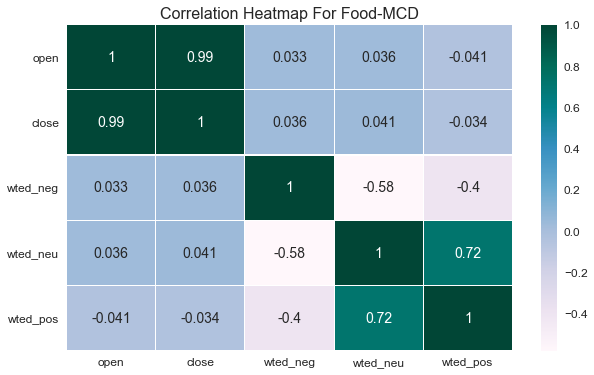

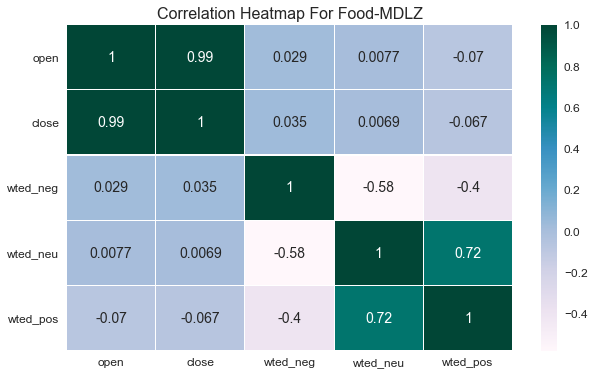

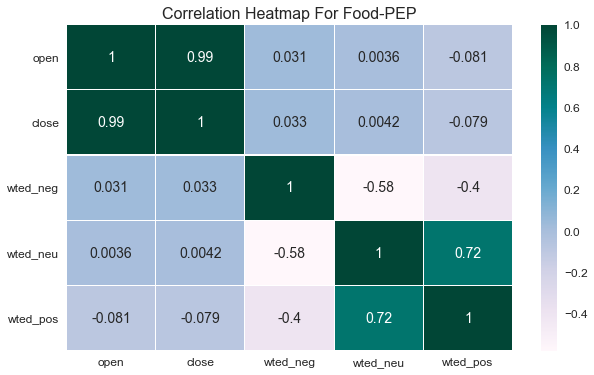

In [12]:
plot_corr_heatmaps(categories, tickers, norm_dfs, save=True)